In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
# metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

In [113]:
df_real = pd.read_csv('workingfolder\df_train.csv')
df_syn = pd.read_csv('synthetic.csv')
df_test = pd.read_csv('workingfolder\df_val.csv')

In [114]:
len(df_real)

237

In [115]:
len(df_syn)

237

In [116]:
df_real.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,51,1,3,100,222,0,0,143,1,1.2,2,0,3,0
1,35,1,4,126,282,0,2,156,1,0.0,1,0,7,1
2,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
3,40,1,1,140,199,0,0,178,1,1.4,1,0,7,0
4,58,0,4,100,248,0,2,122,0,1.0,2,0,3,0


In [117]:
num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [118]:
scaler = StandardScaler()
scaler_syn = StandardScaler()

# For Real
df_real_processed = df_real.copy(deep = True)
df_real_processed[num_features] = scaler.fit_transform(df_real[num_features])
df_test_processed = df_test.copy(deep = True)
df_test_processed[num_features] = scaler.transform(df_test[num_features])

# For Synthetic
df_syn_processed = df_real.copy(deep = True)
df_syn_processed[num_features] = scaler_syn.fit_transform(df_syn[num_features])
df_syn_test_processed = df_test.copy(deep = True)
df_syn_test_processed[num_features] = scaler_syn.transform(df_syn_test_processed[num_features])

In [119]:
X_real = df_real_processed.drop('target', axis = 1)
y_real = df_real_processed['target']

X_syn = df_syn_processed.drop('target', axis = 1)
y_syn = df_syn_processed['target']

X_test = df_test_processed.drop('target', axis = 1)
y_test = df_test_processed['target']

X_test_syn = df_syn_test_processed.drop('target', axis = 1)
y_test_syn = df_syn_test_processed['target']

In [120]:
rfc_real = RandomForestClassifier(n_estimators = 25, max_depth = 5)
rfc_real.fit(X_real, y_real)

RandomForestClassifier(max_depth=5, n_estimators=25)

In [121]:
def performance_metrics(model, X, y):

    y_pred = model.predict(X)

    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(data=cm,
                        index=['True Negative: 0', 'True Positive: 1'],
                        columns=['Pred Negative: 0', 'Pred Positive: 1'])
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')

    print("\n" "#=====#=====#===== Classification Report =====#=====#=====#")
    print(classification_report(y, y_pred))

def plot_evaluation_curves(model, X_train, X_test, y_train, y_test):
    performance_metrics = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for dataset, X, y in [('train', X_train, y_train), ('test', X_test, y_test)]:

        #=====#=====#=====#=====#=====
        # Compute metrics: Accuracy, F1, ROC AUC, Average Precision (AP)
        #=====#=====#=====#=====#=====
        performance_metrics[dataset] = {}

        y_pred = model.predict(X)
        y_pred_prob = model.predict_proba(X)[:, 1]

        # Accuracy
        accuracy = accuracy_score(y, y_pred)
        performance_metrics[dataset]['Accuracy'] = accuracy

        # F1
        f1 = f1_score(y, y_pred)
        performance_metrics[dataset]['F1'] = f1

        # ROC AUC
        roc_auc = roc_auc_score(y, y_pred_prob)
        performance_metrics[dataset]['ROC_AUC'] = roc_auc

        # Average Precision (AP)
        average_precision = average_precision_score(y, y_pred_prob)
        performance_metrics[dataset]['Average_Precision'] = average_precision

        #=====#=====#=====#=====#=====
        # Plot curves: F1 score, ROC, PRC
        #=====#=====#=====#=====#=====
        color = 'blue' if dataset == 'train' else 'orange'

        # F1 score
        thresholds = np.linspace(start=0, stop=1, num=100, endpoint=True)
        f1_scores = [f1_score(y, y_pred_prob >= th) for th in thresholds]
        max_f1_score_idx = np.argmax(f1_scores)

        ax = axs[0]
        ax.plot(thresholds, f1_scores, color=color, label=f"{dataset}, max={round(f1_scores[max_f1_score_idx], 2)} @ {round(thresholds[max_f1_score_idx], 2)}")
        # mark some thresholds
        for th in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            closest_threshold_idx = np.argmin(np.abs(thresholds-th))
            marker_color = 'red'
            ax.plot(thresholds[closest_threshold_idx], f1_scores[closest_threshold_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('decision function threshold')
        ax.set_ylabel('F1')
        ax.set_title('F1 Score')
        ax.legend(loc='lower center')


        # ROC
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f"{dataset}, ROC AUC={round(roc_auc, 2)}")
        # mark some thresholds
        for th in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            closest_threshold_idx = np.argmin(np.abs(thresholds-th))
            marker_color = 'red'
            ax.plot(fpr[closest_threshold_idx], tpr[closest_threshold_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC Curve')
        ax.legend(loc='lower center')

        # PRC
        precision, recall, thresholds = precision_recall_curve(y, y_pred_prob)

        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f"{dataset}, Average Precision={round(average_precision, 2)}")
        # mark some thresholds
        for th in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            closest_threshold_idx = np.argmin(np.abs(thresholds-th))
            marker_color = 'red'
            ax.plot(recall[closest_threshold_idx], precision[closest_threshold_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision Recall Curve')
        ax.legend(loc='lower center')


    df_performance_metrics = pd.DataFrame(performance_metrics).round(2)
    display(df_performance_metrics)



#=====#=====#===== Classification Report =====#=====#=====#
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       131
           1       0.97      0.92      0.94       106

    accuracy                           0.95       237
   macro avg       0.95      0.95      0.95       237
weighted avg       0.95      0.95      0.95       237



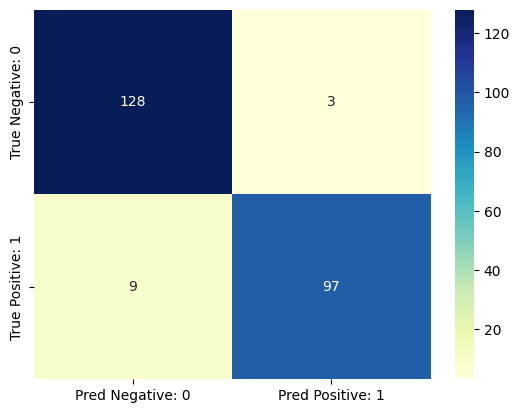

In [122]:
performance_metrics(rfc_real, X_real, y_real)


#=====#=====#===== Classification Report =====#=====#=====#
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        29
           1       0.85      0.71      0.77        31

    accuracy                           0.78        60
   macro avg       0.79      0.79      0.78        60
weighted avg       0.79      0.78      0.78        60



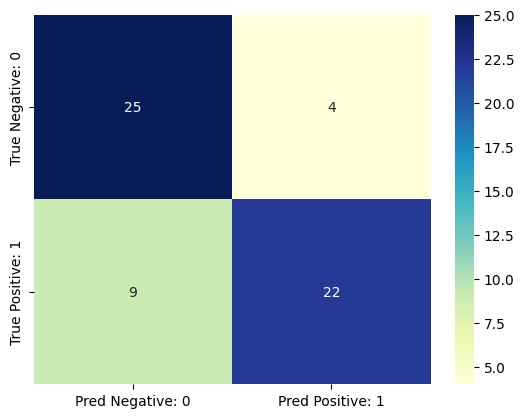

In [123]:
performance_metrics(rfc_real, X_test, y_test)